# 1부. 기초편 데이터 가공
## 01장. 웹에서 주문 수를 분석하는 테크닉 10제 


## 📣 고객의 소리
우리 회사는 오랫동안 쇼핑몰 사이트를 운영하고 있습니다. 고객 정보는 전부 쇼핑몰 사이트에서 관리하고 있어 데이터는 많습니다. 


지금 많은 기업이 데이터 분석으로 성과를 내고 있다고 들어서 우리 회사도 현재 유행하는 데이터 분석을 도입하려고 합니다. 


하지만, 대부분의 사원이 문과 출신이라 데이터 분석에 어둡고 무엇부터 시작해야 할지 잘 모릅니다. 

지금 상황에서는 이번 달 매출을 파악하는 것만으로도 벅찹니다. 

우리 회사 쇼핑몰 사이트의 데이터 분석을 부탁드립니다.

<br>

## 📍 전제조건

이 쇼핑몰의 주요 품목은 컴퓨터입니다. 가격대별로 5개의 상품이 존재합니다.

데이터는 4종류의 6개 데이터가 존재합니다.

In [1]:

import sys
print(sys.version)

3.8.12 | packaged by conda-forge | (default, Sep 29 2021, 19:21:23) 
[Clang 11.1.0 ]


In [ ]:

dir(os)

### 001. 데이터를 읽어 들이자

In [2]:

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from IPython.core.display import display, HTML  # 화면크기 조절
display(HTML("<style>.container { width: 75% !important; }</style>"))

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

In [3]:

customer_master = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/customer_master.csv")
item_master = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/item_master.csv")
transaction_1 = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/transaction_1.csv")
transaction_detail_1 = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/transaction_detail_1.csv")

In [4]:
customer_master.head()

,customer_id,customer_name,registration_date,email,gender,age,birth,pref
0,IK152942,김서준,2019-01-01 0:25,hirata_yuujirou@example.com,M,29,1990-06-10,대전광역시
1,TS808488,김예준,2019-01-01 1:13,tamura_shiori@example.com,F,33,1986-05-20,인천광역시
2,AS834628,김도윤,2019-01-01 2:00,hisano_yuki@example.com,F,63,1956-01-02,광주광역시
3,AS345469,김시우,2019-01-01 4:48,tsuruoka_kaoru@example.com,M,74,1945-03-25,인천광역시
4,GD892565,김주원,2019-01-01 4:54,oouchi_takashi@example.com,M,54,1965-08-05,울산광역시


In [5]:
item_master.head()

,item_id,item_name,item_price
0,S001,PC-A,50000
1,S002,PC-B,85000
2,S003,PC-C,120000
3,S004,PC-D,180000
4,S005,PC-E,210000


In [6]:
transaction_1.head()

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019
2,T0000000115,120000,2019-02-01 02:34:19,HD298120
3,T0000000116,210000,2019-02-01 02:47:23,IK452215
4,T0000000117,170000,2019-02-01 04:33:46,PL542865


In [7]:
transaction_detail_1

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1
1,1,T0000000114,S001,1
2,2,T0000000115,S003,1
3,3,T0000000116,S005,1
4,4,T0000000117,S002,2
...,...,...,...,...
4995,4995,T0000004865,S003,1
4996,4996,T0000004866,S001,3
4997,4997,T0000004867,S001,3
4998,4998,T0000004868,S005,1


### 002. 데이터를 결합(유니언) 해보자

In [8]:

transaction_2 = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/transaction_2.csv")
transaction = pd.concat([transaction_1, transaction_2], ignore_index=True)

transaction_detail_2 = pd.read_csv("/Users/jeongjihwan/Downloads/pyda100-master/1장/transaction_detail_2.csv")
transaction_detail = pd.concat([transaction_detail_1, transaction_detail_2], ignore_index=True)

In [9]:

transaction.head()

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019
2,T0000000115,120000,2019-02-01 02:34:19,HD298120
3,T0000000116,210000,2019-02-01 02:47:23,IK452215
4,T0000000117,170000,2019-02-01 04:33:46,PL542865


In [10]:

# 세로 결합
print(len(transaction_1))
print(len(transaction_2))
print(len(transaction))

5000
1786
6786


In [12]:

transaction_detail.query("transaction_id == 'T0000000113'")  

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1


### 003. 매출 데이터끼리 결합(조인) 해보자

In [13]:

join_data = pd.merge(transaction_detail, transaction[["transaction_id", "payment_date", "customer_id"]], how="left", on="transaction_id")
join_data

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019
2,2,T0000000115,S003,1,2019-02-01 02:34:19,HD298120
3,3,T0000000116,S005,1,2019-02-01 02:47:23,IK452215
4,4,T0000000117,S002,2,2019-02-01 04:33:46,PL542865
...,...,...,...,...,...,...
7139,7139,T0000006894,S004,1,2019-07-31 21:20:44,HI400734
7140,7140,T0000006895,S002,1,2019-07-31 21:52:48,AS339451
7141,7141,T0000006896,S001,2,2019-07-31 23:35:25,OA027325
7142,7142,T0000006897,S002,1,2019-07-31 23:39:35,TS624738


### 004. 마스터데이터를 결합(조인) 해보자

In [14]:

join_data = pd.merge(join_data, customer_master, how="left", on="customer_id")
join_data = pd.merge(join_data, item_master, how="left", on="item_id")
join_data

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,email,gender,age,birth,pref,item_name,item_price
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502,김태경,2019-01-07 14:34,imoto_yoshimasa@example.com,M,30,1989-07-15,대전광역시,PC-E,210000
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019,김영웅,2019-01-27 18:00,mifune_rokurou@example.com,M,73,1945-11-29,서울특별시,PC-A,50000
2,2,T0000000115,S003,1,2019-02-01 02:34:19,HD298120,김강현,2019-01-11 8:16,yamane_kogan@example.com,M,42,1977-05-17,광주광역시,PC-C,120000
3,3,T0000000116,S005,1,2019-02-01 02:47:23,IK452215,김주한,2019-01-10 5:07,ikeda_natsumi@example.com,F,47,1972-03-17,인천광역시,PC-E,210000
4,4,T0000000117,S002,2,2019-02-01 04:33:46,PL542865,김영빈,2019-01-25 6:46,kurita_kenichi@example.com,M,74,1944-12-17,광주광역시,PC-B,85000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7139,7139,T0000006894,S004,1,2019-07-31 21:20:44,HI400734,김윤성,2019-01-04 13:24,shishido_akira@example.com,M,64,1955-01-13,대구광역시,PC-D,180000
7140,7140,T0000006895,S002,1,2019-07-31 21:52:48,AS339451,김무경,2019-02-11 19:34,aihara_miki@example.com,F,74,1945-02-03,대구광역시,PC-B,85000
7141,7141,T0000006896,S001,2,2019-07-31 23:35:25,OA027325,박준석,2019-04-17 9:23,matsuda_saki@example.com,F,40,1979-05-25,서울특별시,PC-A,50000
7142,7142,T0000006897,S002,1,2019-07-31 23:39:35,TS624738,이가빈,2019-02-20 18:15,shinndou_masatoshi@example.com,M,56,1963-02-21,인천광역시,PC-B,85000


* 즉, 총 처음 4종류의 데이터를 하나의 데이터셋으로 완성(union & join을 통해)

### 005. 필요한 데이터 칼럼을 만들자

In [15]:
import sklearn
sklearn.__version__

'1.0.1'

In [16]:
join_data.columns

Index(['detail_id', 'transaction_id', 'item_id', 'quantity', 'payment_date',
       'customer_id', 'customer_name', 'registration_date', 'email', 'gender',
       'age', 'birth', 'pref', 'item_name', 'item_price'],
      dtype='object')

In [17]:

join_data["price"] = join_data["quantity"] * join_data["item_price"]
join_data[['quantity', 'item_price', 'price']]

,quantity,item_price,price
0,1,210000,210000
1,1,50000,50000
2,1,120000,120000
3,1,210000,210000
4,2,85000,170000
...,...,...,...
7139,1,180000,180000
7140,1,85000,85000
7141,2,50000,100000
7142,1,85000,85000


### 006. 데이터를 검산하자

In [18]:

print(join_data["price"].sum())
print(transaction["price"].sum())

971135000
971135000


### 007. 각종 통계량을 파악하자

In [19]:

join_data.isna().sum()

detail_id            0
transaction_id       0
item_id              0
quantity             0
payment_date         0
customer_id          0
customer_name        0
registration_date    0
email                0
gender               0
age                  0
birth                0
pref                 0
item_name            0
item_price           0
price                0
dtype: int64

In [20]:

join_data.describe()

,detail_id,quantity,age,item_price,price
count,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000
mean,3571.500000,1.199888,50.265677,121698.628219,135937.150056
std,2062.439494,0.513647,17.190314,64571.311830,68511.453297
min,0.000000,1.000000,20.000000,50000.000000,50000.000000
25%,1785.750000,1.000000,36.000000,50000.000000,85000.000000
50%,3571.500000,1.000000,50.000000,102500.000000,120000.000000
75%,5357.250000,1.000000,65.000000,187500.000000,210000.000000
max,7143.000000,4.000000,80.000000,210000.000000,420000.000000


In [21]:

join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7144 entries, 0 to 7143
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   detail_id          7144 non-null   int64 
 1   transaction_id     7144 non-null   object
 2   item_id            7144 non-null   object
 3   quantity           7144 non-null   int64 
 4   payment_date       7144 non-null   object
 5   customer_id        7144 non-null   object
 6   customer_name      7144 non-null   object
 7   registration_date  7144 non-null   object
 8   email              7144 non-null   object
 9   gender             7144 non-null   object
 10  age                7144 non-null   int64 
 11  birth              7144 non-null   object
 12  pref               7144 non-null   object
 13  item_name          7144 non-null   object
 14  item_price         7144 non-null   int64 
 15  price              7144 non-null   int64 
dtypes: int64(5), object(11)
memory usage: 948.

In [22]:

print(join_data["payment_date"].min())
print(join_data["payment_date"].max())

2019-02-01 01:36:57
2019-07-31 23:41:38


### 008. 월별로 데이터를 집계해보자

In [44]:
join_data["payment_date"].dt.year

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
7139    2019
7140    2019
7141    2019
7142    2019
7143    2019
Name: payment_date, Length: 7144, dtype: int64

In [23]:

join_data["payment_date"] = pd.to_datetime(join_data["payment_date"])
join_data["payment_month"] = join_data["payment_date"].dt.strftime("%Y%m")
join_data[["payment_date", "payment_month"]]

,payment_date,payment_month
0,2019-02-01 01:36:57,201902
1,2019-02-01 01:37:23,201902
2,2019-02-01 02:34:19,201902
3,2019-02-01 02:47:23,201902
4,2019-02-01 04:33:46,201902
...,...,...
7139,2019-07-31 21:20:44,201907
7140,2019-07-31 21:52:48,201907
7141,2019-07-31 23:35:25,201907
7142,2019-07-31 23:39:35,201907


In [50]:
join_data["payment_date"].dt.strftime("%Y%m")

0       201902
1       201902
2       201902
3       201902
4       201902
         ...  
7139    201907
7140    201907
7141    201907
7142    201907
7143    201907
Name: payment_date, Length: 7144, dtype: object

* strftime( )메소드는 Datetime을 특정 형식 코드로 입력하고 출력에 지정된 특정 형식을 나타내는 문자열을 리턴합니다.
* strftime 은 날짜 객체를 문자열로 변환하는 것
* https://docs.python.org/ko/3/library/datetime.html#strftime-strptime-behavior (파이썬 공식문서에서 변환 형식 참고)

In [25]:

# 반년 동안의 매출 데이터
join_data.groupby("payment_month").sum()["price"]

payment_month
201902    160185000
201903    160370000
201904    160510000
201905    155420000
201906    164030000
201907    170620000
Name: price, dtype: int64

### 009. 월별, 상품별로 데이터를 집계해보자

In [69]:

join_data.groupby(["payment_month", "item_name"]).sum()[["price", "quantity"]]

price  quantity
payment_month item_name                    
201902        PC-A       24150000       483
              PC-B       25245000       297
              PC-C       19800000       165
              PC-D       31140000       173
              PC-E       59850000       285
201903        PC-A       26000000       520
              PC-B       25500000       300
              PC-C       19080000       159
              PC-D       25740000       143
              PC-E       64050000       305
201904        PC-A       25900000       518
              PC-B       23460000       276
              PC-C       21960000       183
              PC-D       24300000       135
              PC-E       64890000       309
201905        PC-A       24850000       497
              PC-B       25330000       298
              PC-C       20520000       171
              PC-D       25920000       144
              PC-E       58800000       280
201906        PC-A       26000000       520
              PC-B       23970000       282
              PC-C       21840000       182
              PC-D       28800000       160
              PC-E       63420000       302
201907        PC-A       25250000       505
              PC-B       28220000       332
              PC-C       19440000       162
              PC-D       26100000       145
              PC-E       71610000       341

* 출력 결과가 직관적으로 이해하기 어려우니 pivot_table로 변환


* 피벗(Pivot) 테이블이란 많은 양의 데이터에서 필요한 자료만을 뽑아 새롭게 표를 작성해 주는 기능입니다. 
* 피벗 테이블을 사용하면 사용자 임의대로 데이터를 정렬하고 필터링 할 수 있씁니다.

In [82]:

pd.pivot_table(join_data, index="item_name", columns="payment_month", values=["price", "quantity"], aggfunc=np.sum)

price                                                    \
payment_month    201902    201903    201904    201905    201906    201907   
item_name                                                                   
PC-A           24150000  26000000  25900000  24850000  26000000  25250000   
PC-B           25245000  25500000  23460000  25330000  23970000  28220000   
PC-C           19800000  19080000  21960000  20520000  21840000  19440000   
PC-D           31140000  25740000  24300000  25920000  28800000  26100000   
PC-E           59850000  64050000  64890000  58800000  63420000  71610000   

              quantity                                     
payment_month   201902 201903 201904 201905 201906 201907  
item_name                                                  
PC-A               483    520    518    497    520    505  
PC-B               297    300    276    298    282    332  
PC-C               165    159    183    171    182    162  
PC-D               173    143    135    144    160    145  
PC-E               285    305    309    280    302    341

### 010. 상품별 매출 추이를 가시화해보자

In [87]:

graph_data = pd.pivot_table(join_data, index="payment_month", columns="item_name", values="price", aggfunc=np.sum)
graph_data

item_name,PC-A,PC-B,PC-C,PC-D,PC-E
payment_month,,,,,
201902,24150000,25245000,19800000,31140000,59850000
201903,26000000,25500000,19080000,25740000,64050000
201904,25900000,23460000,21960000,24300000,64890000
201905,24850000,25330000,20520000,25920000,58800000
201906,26000000,23970000,21840000,28800000,63420000
201907,25250000,28220000,19440000,26100000,71610000


In [88]:

type(graph_data)

pandas.core.frame.DataFrame

* 피벗테이블도 데이터프레임

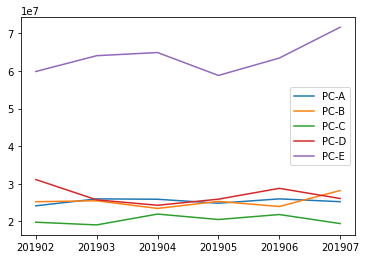

In [98]:

# 반년간 월별 상품별 매출 추이 그래프
import matplotlib.pyplot as plt

plt.plot(list(graph_data.index), graph_data["PC-A"], label="PC-A")
plt.plot(list(graph_data.index), graph_data["PC-B"], label="PC-B")
plt.plot(list(graph_data.index), graph_data["PC-C"], label="PC-C")
plt.plot(list(graph_data.index), graph_data["PC-D"], label="PC-D")
plt.plot(list(graph_data.index), graph_data["PC-E"], label="PC-E")
plt.legend()
plt.show()

* 간단하게 살펴본 결과
* PC-E 상품의 매출규모가 크고 비싼 상품이기에 매출에 견인하는 비중이 상대적으로 매우 큰것을 파악할 수 있음.